In [211]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
from sherpa.astro.data import DataPHA
from sherpa.astro.io import read_pha, read_arf, read_rmf
from astropy.io import fits
import os
from sherpa.astro.io import read_arf, read_rmf
from sherpa.astro.plot import DataPHAPlot
import copy

In [113]:
# for source_dir in os.listdir('spectra_files'):
#     source_path = os.path.join('spectra_files', source_dir)
#     if os.path.isdir(source_path):
#         for obsid_dir in os.listdir(source_path):
#             obsid_path = os.path.join(source_path, obsid_dir)
#             if os.path.isdir(obsid_path):
#                 obsid_trimmed = f'{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}'
#                 print(obsid_trimmed)

In [ ]:
# Load in all of the spectra for each observation for each detector as DataPHA objects and in the 
# process assign the response files and background (and background subtract)

spectra = {}
for source_dir in os.listdir('spectra_files'):
    source_path = os.path.join('spectra_files', source_dir)
    if os.path.isdir(source_path):
        for obsid_dir in os.listdir(source_path):
            obsid_path = os.path.join(source_path, obsid_dir)
            if os.path.isdir(obsid_path):
                obsid_trimmed = f'{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}'
                if obsid_trimmed != 'her_x-1/01001899': # for some reason the rmf doesn't work with this one
                    print(f'Processing {obsid_trimmed}')

                    stokes = ['I', 'Q', 'U']
                    for stoke in stokes:
                        for det in range(1, 4):
                            src_spec_hdu = fits.open(f'{obsid_path}/ixpe_det{det}_src_{stoke}.pha')
                            pha = read_pha(src_spec_hdu)
                            if stokes == 'I':
                                arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.arf')
                            else:
                                arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.mrf')
                            rmf = read_rmf(f'responses/ixpe_d{det}_20170101_alpha075_02.rmf')
                            pha.set_response(arf, rmf)  
                            pha.set_analysis('energy')
                            pha.notice(2, 8)
                            pha.subtract()
                            spectra[f'{obsid_trimmed}/det{det}_{stoke}_pha'] = pha
                        


Processing swift_j1727/03006001
statistical errors were found in file 'spectra_files/swift_j1727/03006001/ixpe_det1_src_I.pha'
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'spectra_files/swift_j1727/03006001/ixpe_det1_bkg_I.pha'
but not used; to use them, re-read with use_errors=True
read background file spectra_files/swift_j1727/03006001/ixpe_det1_bkg_I.pha
statistical errors were found in file 'spectra_files/swift_j1727/03006001/ixpe_det2_src_I.pha'
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'spectra_files/swift_j1727/03006001/ixpe_det2_bkg_I.pha'
but not used; to use them, re-read with use_errors=True
read background file spectra_files/swift_j1727/03006001/ixpe_det2_bkg_I.pha
statistical errors were found in file 'spectra_files/swift_j1727/03006001/ixpe_det3_src_I.pha'
but not used; to use them, re-read with use_errors=True
statistical errors were found in file 'spectra_files/swift_j1

In [ ]:
# pha = spectra['4u_1538-52/03002701/det1_I_pha']
# pha.group_width(5) # group 5 channels per bin, which ends up being a bin spacing of .2 keV (150 channels 6keV*5bins/keV = 30 bins, 150/30=5)
# pha.set_analysis(quantity='energy', type='counts')
# len(pha.get_dep())

375

(2.0, 8.0)

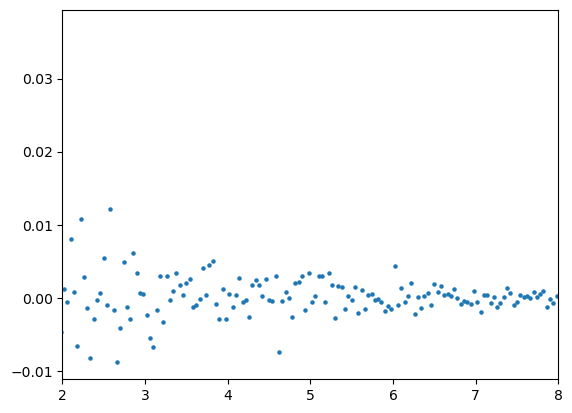

In [217]:
def SumDetectors(obsid_path, stoke):
    phas = np.array([])
    exposures = np.array([])
    counts = np.array([])
    rates = np.array([])
    for i in range(1, 4):
        pha = spectra[f'{obsid_path}/det{i}_{stoke}_pha']
        pha.group_width(1)
        pha.set_analysis('energy', 'rate')
        rate = copy.copy(pha.get_y())
        pha.set_analysis('energy', 'counts')
        # pha.group_width(5)
        count = copy.copy(pha.counts)
        pha.set_analysis('energy', 'counts')
        count = pha.counts
        exposure = count/rate
        exposure[np.isnan(exposure)] = 0
        phas = np.append(phas, pha)
        exposures = np.append(exposures, exposure)
        counts = np.append(counts, count)
        rates = np.append(rates, rate)

    totalExposure = np.sum(exposures.reshape(3, -1), axis=0)
    totalCounts = np.sum(counts.reshape(3, -1), axis=0)
    totalFlux = totalCounts/totalExposure
    return totalFlux, phas, totalExposure, exposures, totalCounts, counts

flux, phas, totalExposure, exposures, totalCounts, counts = SumDetectors('4u_1538-52/03002801', 'Q')
fig, ax = plt.subplots()
# print(len(phas[0].x), flux)
ax.scatter(phas[0].x, flux, s=5)
ax.set_xlim(2, 8)